# Appendicitis Classification

<a name='1'></a>
# 1 - Setup and Imports

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import category_encoders as ce

import tempfile, urllib, zipfile
import scipy

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve)
import xgboost as xgb
from tqdm.notebook import tqdm

import pickle
import pandoc
import shap
from scipy import stats
from scipy.stats import chi2_contingency

#Suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
xgb.__version__

'2.0.3'

<a name='2'></a>
# 2 - Load the Dataset

<a name='2-1'></a>
## 2.1 Read and Split the Dataset

In [13]:
# Read xlsx data into a dataframe and recognize the missing data that is encoded with '?' string as NaN
df_appendicitis_PoC = pd.read_excel('C:/Users/anoes/OneDrive/Documents/Aanstelling RadboudUMC/07_SEH/03_Analyses/AI_Appendicitis_Dataset.xlsx')

<a name='2-2'></a>
## 2.2 Clean up data, select features, check for null values

### 2.2.1 Drop features with considerable missingness

In [14]:
#drop all rows where more 95 out of 130 features is missing
df_appendicitis_PoC.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 135 columns):
 #    Column                              Non-Null Count  Dtype  
---   ------                              --------------  -----  
 0    Unnamed: 0                          336 non-null    int64  
 1    pseudo_id                           336 non-null    object 
 2    dataset                             336 non-null    object 
 3    defense musculaire                  336 non-null    object 
 4    abdomen drukpijn locatie            336 non-null    object 
 5    beloop klachten                     336 non-null    object 
 6    kortademig                          336 non-null    object 
 7    migratie                            336 non-null    object 
 8    ontstaan klachten                   336 non-null    object 
 9    ontlasting kleur                    336 non-null    object 
 10   psoas sign                          336 non-null    object 
 11   longen                        

### 2.2.2 Select & Map Features of Interest

In [18]:
# Features of interest
                  
FEATURE_KEYS_test = ['aantal_seh_bezoeken','gender', 'seh_age_at_time_of_event', 'vervoerder', 'herkomst', 'defense musculaire', 'temperatuur', 'saturatie', 'sys_bp', 
                     'dias_bp', 'map_bp', 'emv', 'sirs', 'ademfrequentie', 'q_sofa','abdomen drukpijn locatie', 'beloop klachten', 'kortademig', 'migratie', 
                       'ontstaan klachten', 'ontlasting kleur', 'psoas sign', 'longen', 'menstruatie afwijkend', 
                       'inguinaal', 'hernia', 'buitenland geweest', 'voorgeschiedenis', 'ontlasting melaena', 'pyrosis', 
                       'eetlust', 'malaise klachten', 'anticonceptie', 'laatste ontlasting', 
                       'abdomen percussie', 'klam of zweten', 'aanwezigheid pijn', 'opgezwollen buik (anamnese)', 
                       'peritoneale prikkeling', 'mictie kleur', 'misselijkheid', 'koude rillingen', 'mictie hematurie', 
                       'mictie dysurie', 'abdomen percussie pijn', 'aard van de pijn', 'hart', 'na vettig eten', 'podb', 
                       'ontlasting slijm', 'stoma', 'ontlasting consistentie', 'bewegingsdrang', 'hoesten', 
                       'abdomen palpatie soepel', "murphy's sign", 'loslaatpijn', 'zwangerschap', 'uitstraling', 
                       'mictie pollakisurie', 'omgeving klachten', 'braken', 'fluor', 'braken bloed', 'vervoerspijn', 
                       'bijgeluiden', 'contralaterale loslaat-/drukpijn', 'locatie pijn', 'mictie strangurie', 'soa-risico',
                       'koorts', 'abdomen auscultatie karakter', 'slagpijn nierloges', 'eerdere episode', 'pijn beweging', 
                       'abdomen palpatie afwijkend', 'ontlasting bloed', 'abdomen drukpijn locatie mcburney', 
                       'familieanamnese relevant afwijkend', 'abdomen palpatie drukpijn', 'abdomen auscultatie aanwezigheid',
                       'abdomen inspectie', 'ademhaling pijn', 'eerdere diagnostiek', 'na voedselinname', 'duur klachten category', 
                       'algemene indruk category', 'crp', 'leucocyten', 'hb', 'mcv', 'erytrocieten', 'trombocyten', 'hematocriet', 'kreatinine', 'ureum', 'a_bilirubine_totaal', 
                       'b_bilirubine_direct', 'alat', 'asat', 'alk_fosfatase', 'gamma_gt', 'lipase', 'natrium', 'kalium', 'calcium', 'chloride', 
                       'e_gfr_ckd_epi', 'ck', 'ld', 'glucose', 'eiwit_totaal', 'albumine', 'neutrofielen', 'eosinofielen', 'lymfocyten', 
                       'basofielen', 'monocyten', 'ph_waarde_u', 'leukocyten_u','glucose_u','nitriet_u','ketonen_u','eiwit_u','bloed_u',
                       'hcg_zwangerschapstest','pijnscore_comb', 'hartfrequentie_adj']

FEATURE_KEYS_test_ENC = ['gender', 'vervoerder', 'herkomst','defense musculaire', 'abdomen drukpijn locatie', 'beloop klachten', 'kortademig', 'migratie', 'ontstaan klachten', 'ontlasting kleur', 'psoas sign', 'longen', 'menstruatie afwijkend', 'inguinaal', 'hernia', 'buitenland geweest', 'voorgeschiedenis', 'ontlasting melaena', 'pyrosis',  'eetlust', 'malaise klachten', 'anticonceptie', 'laatste ontlasting', 'abdomen percussie', 'klam of zweten', 'aanwezigheid pijn', 'opgezwollen buik (anamnese)', 'peritoneale prikkeling', 'mictie kleur', 'misselijkheid', 'koude rillingen', 'mictie hematurie', 'mictie dysurie', 'abdomen percussie pijn', 'aard van de pijn', 'hart', 'na vettig eten', 'podb', 'ontlasting slijm', 'stoma', 'ontlasting consistentie', 'bewegingsdrang', 'hoesten', 'abdomen palpatie soepel', "murphy's sign", 'loslaatpijn', 'zwangerschap', 'uitstraling', 'mictie pollakisurie', 'omgeving klachten', 'braken', 'fluor', 'braken bloed', 'vervoerspijn', 'bijgeluiden', 'contralaterale loslaat-/drukpijn', 'locatie pijn', 'mictie strangurie', 'soa-risico', 'koorts', 'abdomen auscultatie karakter', 'slagpijn nierloges', 'eerdere episode', 'pijn beweging', 'abdomen palpatie afwijkend', 'ontlasting bloed', 'abdomen drukpijn locatie mcburney', 'familieanamnese relevant afwijkend', 'abdomen palpatie drukpijn', 'abdomen auscultatie aanwezigheid', 'abdomen inspectie', 'ademhaling pijn', 'eerdere diagnostiek', 'na voedselinname', 'duur klachten category', 'algemene indruk category', 'leukocyten_u', 'glucose_u', 'nitriet_u', 'ketonen_u', 'eiwit_u', 'bloed_u', 'hcg_zwangerschapstest']


FEATURE_KEYS_test_till_LAB = ['aantal_seh_bezoeken','gender', 'seh_age_at_time_of_event', 'vervoerder', 'herkomst', 'defense musculaire', 'temperatuur', 'saturatie', 'sys_bp', 
                     'dias_bp', 'map_bp', 'emv', 'sirs', 'ademfrequentie', 'q_sofa','abdomen drukpijn locatie', 'beloop klachten', 'kortademig', 'migratie', 
                       'ontstaan klachten', 'ontlasting kleur', 'psoas sign', 'longen', 'menstruatie afwijkend', 
                       'inguinaal', 'hernia', 'buitenland geweest', 'voorgeschiedenis', 'ontlasting melaena', 'pyrosis', 
                       'eetlust', 'malaise klachten', 'anticonceptie', 'laatste ontlasting', 
                       'abdomen percussie', 'klam of zweten', 'aanwezigheid pijn', 'opgezwollen buik (anamnese)', 
                       'peritoneale prikkeling', 'mictie kleur', 'misselijkheid', 'koude rillingen', 'mictie hematurie', 
                       'mictie dysurie', 'abdomen percussie pijn', 'aard van de pijn', 'hart', 'na vettig eten', 'podb', 
                       'ontlasting slijm', 'stoma', 'ontlasting consistentie', 'bewegingsdrang', 'hoesten', 
                       'abdomen palpatie soepel', "murphy's sign", 'loslaatpijn', 'zwangerschap', 'uitstraling', 
                       'mictie pollakisurie', 'omgeving klachten', 'braken', 'fluor', 'braken bloed', 'vervoerspijn', 
                       'bijgeluiden', 'contralaterale loslaat-/drukpijn', 'locatie pijn', 'mictie strangurie', 'soa-risico',
                       'koorts', 'abdomen auscultatie karakter', 'slagpijn nierloges', 'eerdere episode', 'pijn beweging', 
                       'abdomen palpatie afwijkend', 'ontlasting bloed', 'abdomen drukpijn locatie mcburney', 
                       'familieanamnese relevant afwijkend', 'abdomen palpatie drukpijn', 'abdomen auscultatie aanwezigheid',
                       'abdomen inspectie', 'ademhaling pijn', 'eerdere diagnostiek', 'na voedselinname', 'duur klachten category', 
                       'algemene indruk category', 'pijnscore_comb', 'hartfrequentie_adj']

FEATURE_KEYS_test_ENC_till_LAB = ['gender', 'vervoerder', 'herkomst','defense musculaire', 'abdomen drukpijn locatie', 'beloop klachten', 'kortademig', 'migratie', 'ontstaan klachten', 'ontlasting kleur', 'psoas sign', 'longen', 'menstruatie afwijkend', 'inguinaal', 'hernia', 'buitenland geweest', 'voorgeschiedenis', 'ontlasting melaena', 'pyrosis',  'eetlust', 'malaise klachten', 'anticonceptie', 'laatste ontlasting', 'abdomen percussie', 'klam of zweten', 'aanwezigheid pijn', 'opgezwollen buik (anamnese)', 'peritoneale prikkeling', 'mictie kleur', 'misselijkheid', 'koude rillingen', 'mictie hematurie', 'mictie dysurie', 'abdomen percussie pijn', 'aard van de pijn', 'hart', 'na vettig eten', 'podb', 'ontlasting slijm', 'stoma', 'ontlasting consistentie', 'bewegingsdrang', 'hoesten', 'abdomen palpatie soepel', "murphy's sign", 'loslaatpijn', 'zwangerschap', 'uitstraling', 'mictie pollakisurie', 'omgeving klachten', 'braken', 'fluor', 'braken bloed', 'vervoerspijn', 'bijgeluiden', 'contralaterale loslaat-/drukpijn', 'locatie pijn', 'mictie strangurie', 'soa-risico', 'koorts', 'abdomen auscultatie karakter', 'slagpijn nierloges', 'eerdere episode', 'pijn beweging', 'abdomen palpatie afwijkend', 'ontlasting bloed', 'abdomen drukpijn locatie mcburney', 'familieanamnese relevant afwijkend', 'abdomen palpatie drukpijn', 'abdomen auscultatie aanwezigheid', 'abdomen inspectie', 'ademhaling pijn', 'eerdere diagnostiek', 'na voedselinname', 'duur klachten category', 'algemene indruk category']



In [19]:
mapping = {'herkomst': {'Huisarts': 'Huisarts', 
                        'Eigen woonomgeving': 'Zelfverwijzer',
                        'Huisartsenpost': 'Huisarts',
                        'Plaats ongeval': 'Ambulancepersoneel',
                        'Poli/afdeling eigen zkhs': 'Ziekenhuis',
                        'Radiologie': 'Ziekenhuis',
                        'Ander ziekenhuis NL': 'Ziekenhuis',
                        'Overige zorginstelling': 'Overige zorginstelling',
                        'Nederland': 'Onbekend',
                        'nederlands': 'Onbekend',
                        'NL': 'Onbekend',
                        '[FIRSTNAME]': 'Onbekend',
                       }         
                }       
df_appendicitis_PoC.replace(mapping, inplace=True)

## 2.3 Create Alvarado Score 

In [20]:
df_appendicitis_PoC['RLQ_tenderness_alv'] = np.where(df_appendicitis_PoC['abdomen drukpijn locatie'] == "{'rok'}", 2, 0)
df_appendicitis_PoC['rebound_tenderness_alv'] = np.where(df_appendicitis_PoC['loslaatpijn'] == "{'Ja'}", 1, 0) 
df_appendicitis_PoC['temp_alv'] = np.where(df_appendicitis_PoC['temperatuur'] >= 37.3, 1, 0)
df_appendicitis_PoC['RLQ_migration'] = np.where(df_appendicitis_PoC['migratie'] == "{'ROK'}", 1, 0)
df_appendicitis_PoC['anorexia_alv'] = np.where(df_appendicitis_PoC['eetlust'] == "{'Afname'}", 1, 0)
df_appendicitis_PoC['naus_vom_alv'] = np.where((df_appendicitis_PoC['braken'] == "{'Ja'}") | (df_appendicitis_PoC['misselijkheid'] == "{'Ja'}"), 1, 0)
df_appendicitis_PoC['leuco_alv'] = np.where(df_appendicitis_PoC['leucocyten'] >= 10, 2, 0)
df_appendicitis_PoC['neutro_perc_alv'] = np.where(df_appendicitis_PoC['neutrofielen_perc'] > 75, 1, 0)


In [21]:
df_appendicitis_PoC['alvarado_score'] = df_appendicitis_PoC[['RLQ_tenderness_alv', 'rebound_tenderness_alv', 'temp_alv', 'RLQ_migration', 'anorexia_alv', 'naus_vom_alv', 'leuco_alv', 'neutro_perc_alv']].sum(axis=1, numeric_only=True)

## 2.4 Create Cross Validation Dataset 

In [24]:
#Shuffle model development dataset (without Medlon)
df = df_appendicitis_PoC.sample(frac=1, random_state=500)

#Apply one-hot encoding to sex and binary class
compute_dummy = {'GT': {'no appendicitis': 0, 'appendicitis': 1}         
                }       
df.replace(compute_dummy, inplace=True)
#f[['leukocyten_u', 'glucose_u', 'nitriet_u','ketonen_u','eiwit_u','bloed_u', 'hcg_zwangerschapstest']] = df[['leukocyten_u', 'glucose_u', 'nitriet_u','ketonen_u','eiwit_u','bloed_u', 'hcg_zwangerschapstest']].astype(str).astype(int)
#df.head()



### 2.4.1 Encode Categorical Features

In [25]:
for col in FEATURE_KEYS_test_ENC:
    df[col] = df[col].astype('category')

#define our features and the label and split the data:
y = df['GT'] 
X = df[FEATURE_KEYS_test_till_LAB]

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=138, stratify=y)  # 80/20 train-validation set

# Encode categorical features
encoder = ce.CatBoostEncoder(cols=FEATURE_KEYS_test_ENC_till_LAB, return_df=True)
X_train_cat = encoder.fit_transform(X_train, y_train)
X_val_cat = encoder.transform(X_val)

# We can now get the folds using our train set.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=138)
folds = [(train, val) for train, val in cv.split(X_train_cat, y_train)]



## 2.5 Reader Study Analysis

In [50]:
#upload complete reader study
reader_study_cases_filled = pd.read_excel('C:/Users/anoes/OneDrive/Documents/Aanstelling RadboudUMC/07_SEH/03_Analyses/08JUL2024 - Reader_study_uitkomsten_FINAL_ingevuld.xlsx')

In [51]:
reader_study_cases_filled['1A'] = reader_study_cases_filled['1A'] /100
reader_study_cases_filled['1B'] = reader_study_cases_filled['1B'] /100
reader_study_cases_filled['2A'] = reader_study_cases_filled['2A'] /100
reader_study_cases_filled['2B'] = reader_study_cases_filled['2B'] /100
reader_study_cases_filled['3A'] = reader_study_cases_filled['3A'] /100
reader_study_cases_filled['3B'] = reader_study_cases_filled['3B'] /100

In [52]:
reader_study_cases_filled.set_index('idx', inplace=True)

In [53]:
compute_dummy = {'GT': {'no appendicites': 0, 'appendicites': 1}         
                }
reader_study_cases_filled.replace(compute_dummy, inplace=True)

<a name='3'></a>
## 3 -  Model Building

<a name='3-1'></a>
### 3.1 Optuna Hyperparameter Search

In [35]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from collections import Counter
from tqdm import tqdm
import numpy as np
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Define the parameter space for Optuna to search
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_loguniform('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
    }
    num_boost_round = trial.suggest_int('num_boost_round', 50, 1000)
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 10, 50)

    # Dictionary to collect results in
    metrics = ['auc', 'fpr', 'tpr', 'avgp', 'precision', 'recall', 'thresholds']
    results = {
        'train': {m: [] for m in metrics},
        'val': {m: [] for m in metrics}
    }

    # Cross-validation loop
    for train_idx, test_idx in folds:
        X_train_fold, X_val_fold = X_train_cat.iloc[train_idx, :], X_train_cat.iloc[test_idx, :]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Convert data to DMatrix format
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)

        # Train the model
        model = xgb.train(
            dtrain=dtrain,
            params=param,
            evals=[(dtrain, 'train'), (dval, 'val')],
            num_boost_round=num_boost_round,
            verbose_eval=False,
            early_stopping_rounds=early_stopping_rounds
        )

        # Collect results
        sets = [dtrain, dval]
        for i, ds in enumerate(results.keys()):
            y_preds = model.predict(sets[i])
            labels = sets[i].get_label()
            fpr, tpr, thresholds = roc_curve(labels, y_preds)
            precision, recall, thresholds = precision_recall_curve(labels, y_preds)
            results[ds]['fpr'].append(fpr)
            results[ds]['tpr'].append(tpr)
            results[ds]['precision'].append(precision)
            results[ds]['recall'].append(recall)
            results[ds]['thresholds'].append(thresholds)
            results[ds]['auc'].append(roc_auc_score(labels, y_preds))
            results[ds]['avgp'].append(average_precision_score(labels, y_preds))

    # Return the average AUC score for validation sets
    mean_auc = np.mean(results['val']['auc'])
    return mean_auc

# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Best parameters: ", study.best_params)

# Evaluate the final model
print("Final Results: ")
for metric in metrics:
    print(f"Train {metric}: {np.mean(results['train'][metric])}")
    print(f"Val {metric}: {np.mean(results['val'][metric])}")

[I 2024-10-08 16:51:54,705] A new study created in memory with name: no-name-d05416de-6e4c-43a4-99a1-147c5dfeabaf
[I 2024-10-08 16:53:00,810] Trial 0 finished with value: 0.7487700760777684 and parameters: {'eta': 0.13729397891264314, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.7573449395041161, 'colsample_bytree': 0.6872179917914019, 'lambda': 1.2347148721277147e-05, 'alpha': 0.00010176683341312054, 'num_boost_round': 59, 'early_stopping_rounds': 24}. Best is trial 0 with value: 0.7487700760777684.
[I 2024-10-08 16:54:12,331] Trial 1 finished with value: 0.7404953508030431 and parameters: {'eta': 0.10952333525149965, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5570620405219212, 'colsample_bytree': 0.7789152745065018, 'lambda': 1.0214212332132275e-06, 'alpha': 0.04138024213849707, 'num_boost_round': 774, 'early_stopping_rounds': 20}. Best is trial 0 with value: 0.7487700760777684.
[W 2024-10-08 16:54:27,649] Trial 2 failed with parameters: {'eta': 0.1682944807554108

KeyboardInterrupt: 

In [63]:
optuna.importance.get_param_importances(study)

{'min_child_weight': 0.7086795521679927,
 'eta': 0.13986996586611386,
 'colsample_bytree': 0.046630811775871736,
 'early_stopping_rounds': 0.03928656540800789,
 'num_boost_round': 0.023965921700959583,
 'subsample': 0.020735304192367857,
 'max_depth': 0.0194320288259058,
 'lambda': 0.0008845844799145277,
 'alpha': 0.0005152655828659408}

## 3.2 Model Building

In [36]:
#Cost-Sensitive XGBoost for class imbalance 
counter = Counter(y)
# Estimate scale_pos_weight value, with class labels are 0 (not affected) and 1 (affected).
#weight = counter[0] / counter[1]

# Dictionary to collect results in:
metrics = ['auc', 'fpr', 'tpr', 'avgp', 'precision', 'recall', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics}
}

# To initialise XGBoost we have to chose some parameters:
"""
params = {
    'objective'  : 'binary:logistic',
    'eval_metric' : 'auc',
    'eta': 0.037570576528923254,
    'max_depth': 8,
    'min_child_weight': 10,
    'subsample': 0.6523374183668105,
    'colsample_bytree': 0.9043997622431874,
    'lambda': 0.2171774411236415,
    'alpha': 0.009859752527977033
}

"""
# w/o lab
params = {
    'objective'   : 'binary:logistic',
    'eval_metric' : 'auc',
    'eta': 0.015629208905638542,
    'max_depth': 7,
    'min_child_weight': 7,
    'subsample': 0.8052306317794611,
    'colsample_bytree': 0.9377262055447466,
    'lambda': 0.25026720118532253,
    'alpha': 0.002593031047346012
    }

## Run our cross-validation and save all scores to our dictionary
for train, test in tqdm(folds, total=len(folds)):
    X_train_fold, X_val_fold = X_train_cat.iloc[train,:], X_train_cat.iloc[test,:]
    y_train_fold, y_val_fold = y_train.iloc[train], y_train.iloc[test]
    
    # Convert data to DMatrix format
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical = True)
    dval   = xgb.DMatrix(X_val_cat, label=y_val, enable_categorical = True)

    # Train the model
    model = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        #num_boost_round       = 785,
        num_boost_round       = 740, #w/o lab
        verbose_eval          = False,
        #early_stopping_rounds = 46,
        early_stopping_rounds = 45, #w/o lab
    )

    # Collect results
    sets = [dtrain, dval]
    for i, ds in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        precision, recall, thresholds = precision_recall_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['precision'].append(precision)
        results[ds]['recall'].append(recall)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))
        results[ds]['avgp'].append(average_precision_score(labels, y_preds))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:34<00:00,  3.24it/s]


###  Save XGBoost Model

In [65]:
# Train your XGBoost model
# Example:
# xgb_model = xgb.XGBClassifier()
# xgb_model.fit(X_train, y_train)

# Save the model to a file
with open('XGB_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Load the model for predictions
with open('XGB_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# convert
dval = xgb.DMatrix(X_val_cat, label=y_val)
    
# Now, you can use loaded_model to make predictions
predictions = loaded_model.predict(dval)

<a name='4-1'></a>
## 4 - AUROC Plots

<a name='4-2'></a>
### 4.1 ROC Curve

ROC Curve is useful to compare with other models trained with different data but in the same field of research. With the cross validation, the ROC is plotted with a confidence interval to show the robustness of the classifier. 

Sensitivity and specificity are two of the most prominent numbers that are used to measure diagnostics tests.
- Sensitivity is the probability that our test outputs positive given that the case is actually positive.
- Specificity is the probability that the test outputs negative given that the case is actually negative. 

We can phrase this easily in terms of true positives, true negatives, false positives, and false negatives: 

$$sensitivity = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$specificity = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$

- Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
- Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

In [69]:
#100 cross validation folds, we can plot our ROC/PRC curve:
kind = 'val'
c_fill      = 'rgba(45, 130, 164, 0.2)' #102, 134, 142,
c_line      = 'rgba(45, 130, 164, 0.5)' #45, 130, 164,
c_line_main = 'rgba(45, 130, 164, 1.0)' 
c_grid      = 'rgba(45, 130, 164, 0.5)' 
c_annot     = 'rgba(45, 130, 164, 0.5)'
fpr_mean    = np.linspace(0, 1, 100)
interp_tprs = []
for i in range(100):
    fpr           = results[kind]['fpr'][i]
    tpr           = results[kind]['tpr'][i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = 2*np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std
auc          = np.mean(results[kind]['auc'])
fig = go.Figure([
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_upper,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "name+x+y",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
       x          = fpr_mean,
       y          = tpr_lower,
       fill       = 'tonexty',
       fillcolor  = c_fill,
       line       = dict(color=c_line, width=1),
       hoverinfo  = "name+x+y",
       showlegend = False,
       name       = 'lower'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_mean,
        line       = dict(color=c_line_main, width=4, dash='solid'),
        hoverinfo  = "x+y",
        showlegend = True,
        name       = f'HIVE-LAB model AUROC {auc:.3f}' #
      ) 
])
fig.add_shape(
    type ='line', 
    line =dict(dash='dash', width=1, color='grey'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template    = 'plotly_white',
    #paper_bgcolor = 'rgba(0,0,0,0)',
    #plot_bgcolor = 'rgba(0,0,0,0)',
    title_x     = 0.5,
    xaxis_title = "1 - Specificity",
    yaxis_title = "Sensitivity",
    width       = 800,
    height      = 800,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=1.05,
        y=0.02,
        font=dict(
            size=30) 
    )
)
fig.update_yaxes(
    range       = [0.0, 1.0],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black',
    tickfont= dict(size=32),
    title_font=dict(size=32))  #can change the size of font here
fig.update_xaxes(
    range       = [0.0, 1.0],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black',
    tickfont= dict(size=32),
    title_font=dict(size=32))

In [70]:
auc_scores = np.array(results['val']['auc'])
def bootstrap_auc_ci(data, num_bootstrap_samples=10000, ci=95):
    """
    Calculate the confidence interval for AUC using bootstrapping.
    
    Parameters:
    - data: array-like, the AUC scores.
    - num_bootstrap_samples: int, the number of bootstrap samples to generate.
    - ci: float, the confidence interval percentage.

    Returns:
    - lower_bound: float, the lower bound of the confidence interval.
    - upper_bound: float, the upper bound of the confidence interval.
    """
    bootstrapped_scores = []
    n = len(data)
    
    for _ in range(num_bootstrap_samples):
        # Generate a bootstrap sample by sampling with replacement
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        # Calculate the AUC for the bootstrap sample (mean in this case)
        bootstrapped_scores.append(np.mean(bootstrap_sample))
    
    # Convert to a numpy array
    bootstrapped_scores = np.array(bootstrapped_scores)
    # Sort the bootstrapped AUC scores
    sorted_scores = np.sort(bootstrapped_scores)
    
    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = np.percentile(sorted_scores, (100 - ci) / 2)
    upper_bound = np.percentile(sorted_scores, 100 - (100 - ci) / 2)
    
    return lower_bound, upper_bound

# Calculate the 95% confidence interval for the AUC using bootstrapping
ci_lower, ci_upper = bootstrap_auc_ci(auc_scores, num_bootstrap_samples=10000, ci=95)

print("Confidence interval for the AUC: [{:0.3f} - {:0.3f}]".format(ci_lower, ci_upper))

Confidence interval for the AUC: [0.918 - 0.920]


## 4.2  AUC ED Physicians 

In [91]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import plotly.graph_objects as go
from sklearn.utils import resample

# Dummy data setup (example)
compute_dummy = {'GT': {'no appendicitis': 0, 'appendicitis': 1}}  
reader_study_cases_filled.replace(compute_dummy, inplace=True)
label = reader_study_cases_filled['GT'].values

# List to store AUCs of each doctor
doctor_AUCs = []
doctor_CI = []  # To store confidence intervals
doctor_fprs = []
doctor_tprs = []

# Extract predictions of each doctor into separate arrays
doctor_probs = [
    reader_study_cases_filled['1A'].values,
    reader_study_cases_filled['2A'].values,
    reader_study_cases_filled['3A'].values
]

# Define colors for each doctor's ROC curve
colors = ['rgba(102, 134, 142, 1.0)', 'rgba(102, 134, 142, 1.0)', 'rgba(102, 134, 142, 1.0)'] #102, 134, 142
lines = ['solid', 'dash', 'dot']

# Number of bootstrap samples
n_bootstraps = 1000
rng_seed = 42  # Control random number generation for reproducibility

# Create a figure
fig = go.Figure()

# Compute ROC curve, AUC and confidence intervals for each doctor
for i, probs in enumerate(doctor_probs):
    fpr, tpr, thresholds = roc_curve(label, probs)
    auc = roc_auc_score(label, probs)
    doctor_AUCs.append(auc)
    doctor_fprs.append(fpr)
    doctor_tprs.append(tpr)
    
    # Bootstrap
    bootstrapped_scores = []
    rng = np.random.default_rng(rng_seed)
    for _ in range(n_bootstraps):
        # Sample with replacement from the dataset
        indices = rng.integers(0, len(probs), len(probs))
        if len(np.unique(label[indices])) < 2:
            # Skip iteration if the sample does not contain at least one positive and one negative sample
            continue
        score = roc_auc_score(label[indices], probs[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    # Compute the confidence intervals
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    confidence = (confidence_upper - confidence_lower)/2
    doctor_CI.append((confidence_lower, confidence_upper, confidence))
    
    # Add ROC curve for each doctor with customized colors and AUC in the legend
    fig.add_trace(go.Scatter(
        x=doctor_fprs[i],
        y=doctor_tprs[i],
        mode='lines',
        line=dict(color=colors[i], dash=lines[i], width=4),
        name=f'ED physician {i+1} AUROC {auc:.3f} ±{confidence:.3f}'
    ))

# Update layout
fig.update_layout(
    #title="ROC Curves of ED Physicians",
    yaxis_gridcolor   = 'rgba(102, 134, 142, 0.5)',
    xaxis_gridcolor   = 'rgba(102, 134, 142, 0.5)',
    yaxis_range= [0.0, 1.0],
    xaxis_range= [0.0, 1.0],
    xaxis_title="1 - Specificity",
    yaxis_title="Sensitivity",
    xaxis_tickfont= dict(size=32),
    xaxis_title_font=dict(size=32),
    yaxis_tickfont= dict(size=32),
    yaxis_title_font=dict(size=32),
    xaxis_linecolor = 'black',
    yaxis_linecolor = 'black',
    template="plotly_white",
    width=800,
    height=800,
    legend=dict(
        yanchor="bottom",
        xanchor="right",
        x=1.01,
        y=0.01,
        font=dict(size=26, color='black')
        )
)

# Add diagonal dashed line (y=x)
fig.add_shape(
    type='line',
    line=dict(dash='dash', width=0.5),
    x0=0,
    y0=0,
    x1=1,
    y1=1
)

# Show the plot
fig.show()


## 4.3 AUC Alvarado Score

In [59]:
df_appendicitis_PoC['alvarado_score']

0      2
1      4
2      0
3      5
4      5
      ..
331    3
332    9
333    1
334    6
335    2
Name: alvarado_score, Length: 336, dtype: int64

In [60]:
Validatie_Alvarado = X_val_cat.merge(df_appendicitis_PoC, how='left', left_index=True, right_index=True)

In [61]:
Validatie_Alvarado['alvarado_score_adj'] = Validatie_Alvarado['alvarado_score']/10

In [62]:
# Replace categorical labels with numeric values for GT
compute_dummy = {'GT': {'no appendicitis': 0, 'appendicitis': 1}}  
Validatie_Alvarado.replace(compute_dummy, inplace=True)

# Extract the labels and predictions for the Alvarado score
label = Validatie_Alvarado['GT'].values
alvarado_probs = Validatie_Alvarado['alvarado_score_adj'].values

# Compute the AUC for the Alvarado score
auc_alvarado = roc_auc_score(label, alvarado_probs)

print(f"AUC for the Alvarado score: {auc_alvarado:.2f}")

AUC for the Alvarado score: 0.82


In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import plotly.graph_objects as go
from sklearn.utils import resample

# Replace categorical labels with numeric values for GT
compute_dummy = {'GT': {'no appendicitis': 0, 'appendicitis': 1}}  
Validatie_Alvarado.replace(compute_dummy, inplace=True)

# Extract the labels and predictions for the Alvarado score
label = Validatie_Alvarado['GT'].values
alvarado_probs = Validatie_Alvarado['alvarado_score_adj'].values

# Compute ROC curve and AUC for the Alvarado score
fpr, tpr, thresholds = roc_curve(label, alvarado_probs)
auc_alvarado = roc_auc_score(label, alvarado_probs)

# Bootstrap to calculate confidence intervals
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)
bootstrapped_scores = []

tpr_bootstrapped = []

for i in range(n_bootstraps):
    indices = rng.randint(0, len(alvarado_probs), len(alvarado_probs))
    if len(np.unique(label[indices])) < 2:
        # We need at least one positive and one negative sample for AUC to be defined
        continue

    fpr_bootstrap, tpr_bootstrap, _ = roc_curve(label[indices], alvarado_probs[indices])
    auc_bootstrap = roc_auc_score(label[indices], alvarado_probs[indices])
    bootstrapped_scores.append(auc_bootstrap)
    
    interp_tpr = np.interp(fpr, fpr_bootstrap, tpr_bootstrap)
    tpr_bootstrapped.append(interp_tpr)

tpr_bootstrapped = np.array(tpr_bootstrapped)
mean_tpr = np.mean(tpr_bootstrapped, axis=0)
std_tpr = np.std(tpr_bootstrapped, axis=0)

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Compute the lower and upper bound of the 95% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
confidence = (confidence_upper - confidence_lower) / 2

print(f"AUC for the Alvarado score: {auc_alvarado:.2f}")
print(f"95% CI for the Alvarado score: [{confidence_lower:.2f} - {confidence_upper:.2f}]")

# Plotting ROC curve for the Alvarado score
fig = go.Figure()

# Add ROC curve for the Alvarado score
fig.add_trace(go.Scatter(
    x=fpr,
    y=mean_tpr,
    mode='lines',
    line=dict(color='rgba(45, 130, 164, 1.0)', width=3),
    showlegend=True,
    name=f'Alvarado AUROC {auc_alvarado:.3f} ±{confidence:.3f}'
))

# Add confidence interval shading and boundary lines
fig.add_trace(go.Scatter(
    x=np.concatenate([fpr, fpr[::-1]]),
    y=np.concatenate([mean_tpr - 1.96 * std_tpr, (mean_tpr + 1.96 * std_tpr)[::-1]]),
    fill='toself',
    fillcolor='rgba(45, 130, 164, 0.1)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='95% CI'
))

fig.add_trace(go.Scatter(
    x=fpr,
    y=mean_tpr - 1.96 * std_tpr,
    mode='lines',  # Set mode to 'lines'
    line=dict(color='rgba(45, 130, 164, 0.5)', width=1),
    hoverinfo="name+x+y",
    showlegend=False,
    name='Lower CI'
))

fig.add_trace(go.Scatter(
    x=fpr,
    y=mean_tpr + 1.96 * std_tpr,
    mode='lines',  # Set mode to 'lines'
    fill='tonexty',
    fillcolor='rgba(45, 130, 164, 0.1)',
    line=dict(color='rgba(45, 130, 164, 0.5)', width=1),
    hoverinfo="name+x+y",
    showlegend=False,
    name='Upper CI'
))

# Update layout
fig.update_layout(
    
    yaxis_range=[0.0, 1.0],
    xaxis_range=[0.0, 1.0],
    xaxis_title="1 - Specificity<br><sup>Diagonal segments are produced by ties",
    yaxis_title="Sensitivity",
    xaxis_tickfont=dict(size=32),
    xaxis_title_font=dict(size=32),
    yaxis_tickfont=dict(size=32),
    yaxis_title_font=dict(size=32),
    xaxis_linecolor='black',
    yaxis_linecolor='black',
    template="plotly_white",
    width=800,
    height=800,
    legend=dict(
        yanchor="bottom",
        xanchor="right",
        x=1.01,
        y=0.03,
        font=dict(size=28, color='black')
    )
)

# Add diagonal dashed line (y=x)
fig.add_shape(
    type='line',
    line=dict(dash='dash', width=0.5),
    x0=0,
    y0=0,
    x1=1,
    y1=1
)

# Show the plot
fig.show()


AUC for the Alvarado score: 0.82
95% CI for the Alvarado score: [0.72 - 0.91]


In [65]:
len(X_val_cat)

68

In [142]:
y_test_preds_till_lab = model.predict(dval)

In [152]:
Validatie_set['preds_till_lab'] = y_test_preds_till_lab
Validatie_set['preds_with_lab'] = y_test_preds_w_lab
Validatie_set['labels'] = y_test_labels

In [154]:
Validatie_set.to_excel('C:/Users/anoes/OneDrive/Documents/Aanstelling RadboudUMC/07_SEH/04_Results/24JUL2024predictions_validatie_set.xlsx')

# 5. Feature Contributions

<a name='5'></a>
### SHAP Values 
More info: (https://christophm.github.io/interpretable-ml-book/shapley.html)

### SHAP Global Feature Importance Plot 
Global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

#### Feature Redundancy
A hierarchical clustering of the feature by training XGBoost models to predict the outcome for each pair of input features. 


In [71]:
# Explain over 2000 samples in a model with over a thousand trees for XGBoost #38, 42
explainer = shap.TreeExplainer(model)

In [61]:
#explainer = shap.LinearExplainer(logreg_model, med_test)  #138, 138

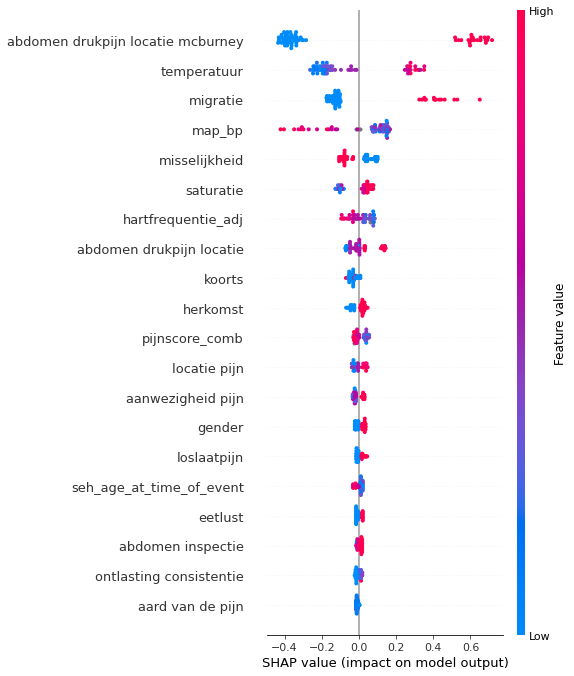

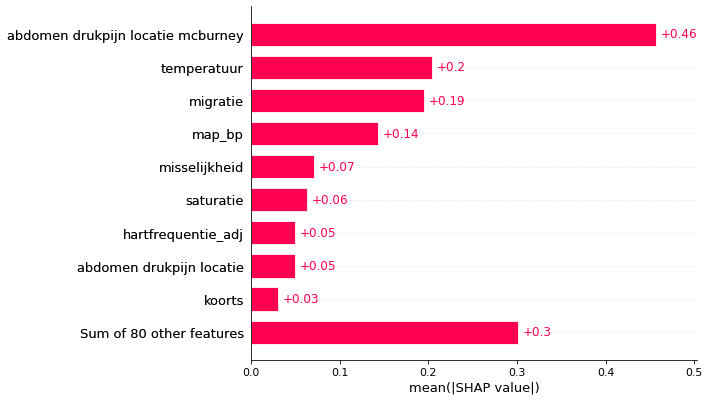

In [72]:
#test set
shap_values = explainer(X_val_cat)

shap.summary_plot(shap_values, X_val_cat)
#clustering = shap.utils.hclust(X_val_cat, y_val) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
#shap.plots.bar(shap_values, clustering=clustering)
shap.plots.bar(shap_values,  max_display=10)

In [73]:
fi_shap = abs(shap_values.values).sum(0)

In [90]:
fi_shap = fi_shap/fi_shap.sum()

In [77]:
FI = np.column_stack([FEATURE_KEYS_test_till_LAB, fi_shap])

In [87]:
FI_df = pd.DataFrame(FI, columns=['FEATURES', 'Importance'])

In [88]:
FI_df['Percentage'] = FI_df['Importance'].astype(float).apply(lambda x: 100 * x).values

<a name='3-3'></a>
# 6. DeLong Test

In [30]:
# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

In [141]:
df_delongtest = pd.read_excel('C:/Users/anoes/OneDrive/Documents/Aanstelling RadboudUMC/07_SEH/04_Results/22AUG2024_deLongTest.xlsx')

In [142]:
df_delongtest.labels = df_delongtest.labels.astype('float64')

In [54]:
labels = df_delongtest['labels'].values
model1 = df_delongtest['alvarado_score_adj'].values
model2 = df_delongtest['preds_till_lab'].values

In [55]:
p_value = delong_roc_test(ground_truth=labels, predictions_one=model1, predictions_two=model2)

C:\Users\anoes\AppData\Local\Temp\ipykernel_24424\2979335442.py:57: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\anoes\AppData\Local\Temp\ipykernel_24424\2979335442.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\anoes\AppData\Local\Temp\ipykernel_24424\2979335442.py:59: DeprecationWarning:

`np.float` is a depreca

In [56]:
actual_p_value = 10**p_value

In [57]:
actual_p_value

array([[0.03328017]])